In [1]:
from examples import Example_Longtime2012,example2ppd,plot_example

## 验证损失函数的正确性

In [2]:
from examples import Example_Longtime2012
from loss import vertify_lossfuncs

exam = Example_Longtime2012
stokes_UVP_func = exam.NS_th
darcy_UVP_func=exam.Darcy_th

    # for k,eqn in eqn_dict.items():
    #     print(f'{k} shape:{eqn.shape}')
eqn_dict = vertify_lossfuncs(exam,stokes_UVP_func,darcy_UVP_func)

for k,eqn in eqn_dict.items():
    print(f'{k} absmax:{eqn.abs().max()} square:{eqn.square().sum(dim=-1).mean()}')

eqn_stokes_1 absmax:3.814697265625e-06 square:8.224305026068024e-13
eqn_stokes_2 absmax:8.940696716308594e-08 square:1.0308577776119154e-11
eqn_darcy_1 absmax:1.1920928955078125e-06 square:3.916117918226908e-14
eqn_darcy_2 absmax:3.814697265625e-06 square:2.622588546330462e-08
eqn_inter_1 absmax:1.7881393432617188e-07 square:1.0811954803680024e-10
eqn_inter_2 absmax:0.0 square:0.0
eqn_inter_3 absmax:9.5367431640625e-07 square:1.881775402168273e-09


c:\Users\haske\miniconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# 模型

全连接神经网络 是一个万能函数拟合。

## 损失函数流程验证

In [3]:
from train import prepare_train,train
from loss import setup_exam2eqns
from network import CombinedNet
import torch as th
rescombinedNet = CombinedNet([32]*6)
stokes_UVP_func = rescombinedNet.NS_th
darcy_UVP_func=rescombinedNet.Darcy_th

eqn_dict = vertify_lossfuncs(exam,stokes_UVP_func,darcy_UVP_func)
for k,eqn in eqn_dict.items():
    print(f'{k} absmax:{eqn.abs().max():g} \t square mean:{eqn.square().mean():g} \t square:{eqn.abs().mean(dim=0).sum():g}')
# for k,eqn in eqn_dict.items():
#     print(f'{k} shape:{eqn.shape}')

eqn_stokes_1 absmax:10.412 	 square mean:18.0859 	 square:6.41192
eqn_stokes_2 absmax:0.00930392 	 square mean:1.35472e-05 	 square:0.00306243
eqn_darcy_1 absmax:0.0836538 	 square mean:0.00249427 	 square:0.0834743
eqn_darcy_2 absmax:14.4846 	 square mean:24.2289 	 square:3.69524
eqn_inter_1 absmax:0.110509 	 square mean:0.0118545 	 square:0.108876
eqn_inter_2 absmax:0.142363 	 square mean:0.0183297 	 square:0.135343
eqn_inter_3 absmax:0.0708352 	 square mean:0.00461807 	 square:0.0679364


## 5. 训练
训练神经网络。

每次迭代取出一部分 初边值条件时空坐标 计算物理量损失 与 整个定义域的时空坐标 计算方程损失。
不同部分的取法以及比例有多种可能性，目前的做法是每次取两个部分的时空坐标量比例1:1，随机采样。

使用 Adam 优化器，初始学习率 0.01 

当迭代次数每达到一定数量时(存在还未被取到的时空坐标点的概率小于1e-5)，计算这段的平均损失 mean_loss,如果 mean_loss 在一定数量的步骤内没有得到改善，则把学习率缩小十倍。当学习率缩小到一定阈值时，训练停止。


Layer (type:depth-idx)                   Param #
CombinedNet                              --
├─StokesNet: 1-1                         --
│    └─DNN: 2-1                          --
│    │    └─Sequential: 3-1              5,507
├─DarcyNet: 1-2                          --
│    └─DNN: 2-2                          --
│    │    └─Sequential: 3-2              5,507
Total params: 11,014
Trainable params: 11,014
Non-trainable params: 0
图片保存在output\train_Example_Longtime2012_CombinedNet_32x6_fd_normed__2022-05-14 00h52m07s\读取到的数据_plot.jpg
PhysicalProcessData - combined_Example_Longtime2012-Stokes 初边值条件... 数据描述：
	时空坐标点个数 : 	19800
	时间点个数 : 	50
	时间T范围 : 	(0.0, 1.0)
	空间维数 : 	2
	空间轴X个数 : 	50
	空间轴X范围 : 	(0.0, 1.0)
	空间轴Y个数 : 	99
	空间轴Y范围 : 	(0.0, 2.0)
	物理量U范围 : 	(-3.4579694, 3.4579694)
	物理量U均值 : 	0.2649492025375366
	物理量U标准差 : 	1.1114946603775024
	物理量V范围 : 	(-1.4266526, 0.81317663)
	物理量V均值 : 	-0.017864441499114037
	物理量V标准差 : 	0.5393843054771423
	物理量P范围 : 	(-0.39940926, 0.7007312)
	物理量P均值 : 	0.162284076

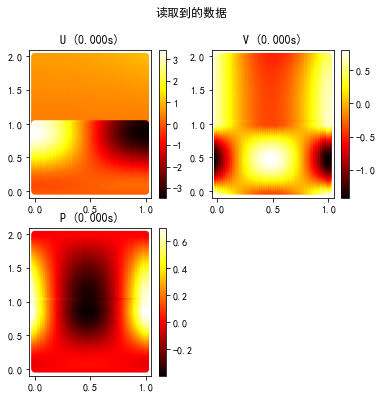

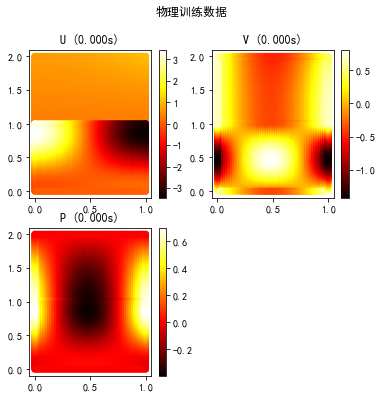

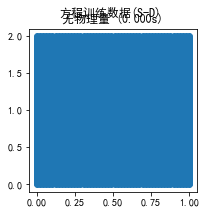

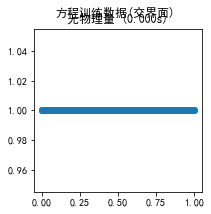

In [4]:
from train import prepare_train,train
from loss import setup_exam2eqns
from network import CombinedNet
import torch as th
rescombinedNet = CombinedNet([32]*6)
from torchinfo import summary
print(summary(rescombinedNet))

from examples import Example_Longtime2012 as exam 
rescombinedNet.stokesNet.set_normalize(th.tensor(list(zip(exam.NS_area['T_range'],exam.NS_area['X_range'],exam.NS_area['Y_range'])),dtype=th.float32))
rescombinedNet.darcyNet.set_normalize(th.tensor(list(zip(exam.Darcy_area['T_range'],exam.Darcy_area['X_range'],exam.Darcy_area['Y_range'])),dtype=th.float32))


stokes, darcy, interface = setup_exam2eqns(exam)
eqnloss_funcs = dict(
    stokes=stokes,
    darcy=darcy,
    interface=interface
)
train_kwargs = prepare_train(exam,rescombinedNet,commit='32x6_fd_normed')

In [5]:
train(rescombinedNet, eqnloss_funcs, **train_kwargs)

执行: tensorboard --logdir="C:\Users\haske\MyFiles\Master\论文\程序\output\train_Example_Longtime2012_CombinedNet_32x6_fd_normed__2022-05-14 00h52m07s\tensorboard"


0it [00:00, ?it/s]

KeyboardInterrupt: 

# 测试与误差

验证损失函数

In [6]:
import torch as th
from test import plot_diff,test_loss
from pathlib import Path
from network import CombinedNet
from examples import Example_Longtime2012
output_dir = Path(r'output\train_Example_Longtime2012_CombinedNet_32x6_fd_normed__2022-05-14 00h52m07s')
test_output_dir = output_dir/'test'
test_output_dir.mkdir(exist_ok=True)

trained_combinedNet = CombinedNet([32]*6)
state_fp = output_dir / 'nsd_net_state.pth'
trained_combinedNet.load_state_dict(th.load(state_fp, map_location=th.device('cpu')))

test_loss(Example_Longtime2012,trained_combinedNet)

eqn_stokes_1: 0.0312329
eqn_stokes_2: 0.00552474
eqn_darcy_1: 0.0227939
eqn_darcy_2: 0.0311915
eqn_inter_1: 0.00271337
eqn_inter_2: 0.00256756
eqn_inter_3: 0.00350025
stokes_U_loss: 4.71955e-06
stokes_V_loss: 1.27038e-05
stokes_P_loss: 6.12529e-05
darcy_U_loss: 5.46424e-05
darcy_V_loss: 5.14142e-05
darcy_P_loss: 5.04113e-06

TotalLoss:0.099714


测试相对误差

In [7]:
import pandas as pd
from examples import example2ppd
exam = Example_Longtime2012
def relative_error(X_pred: th.Tensor, X_true: th.Tensor):
    return th.linalg.norm(X_pred - X_true) / th.linalg.norm(X_true)

def norm_error(X_pred: th.Tensor, X_true: th.Tensor):
    return th.linalg.norm(X_pred - X_true)


stokes_ppd,darcy_ppd = example2ppd(exam)
# pred_stokes_ppd,pred_darcy_ppd = create_ppd(
#     'pred_' + exam.__name__,
#     exam.NS_area,exam.Darcy_area,
#     trained_combinedNet.NS_th,trained_combinedNet.Darcy_th)
stokes_UVP_func = trained_combinedNet.NS_th 
darcy_UVP_func = trained_combinedNet.Darcy_th
error_data = {}
error_data['Stokes'] = {}
error_data['Darcy'] = {}
for error_func,error_name in [[norm_error,'norm_error'],[relative_error,'relative_error']]:
    error_data[error_name] = {}
    
    for ppd,uvp_func,area_name in zip([stokes_ppd,darcy_ppd],[stokes_UVP_func,darcy_UVP_func],['Stokes','Darcy']):
        error_data[error_name][area_name] = {}
        
        for t in [0.0,0.2,0.4,0.6,0.8,1.0]:
            Ts,Xs,Ys,Us,Vs,Ps =  th.from_numpy(ppd.snapshot(t).DataDF.to_numpy(dtype='float32')).unbind(dim=-1)
            with th.no_grad():
                pred_Us,pred_Vs,pred_Ps = uvp_func(Ts,Xs,Ys)

                error_data[error_name][area_name][t] = {}
                for name,truepq,predpq in zip(['U','V','P'],[Us,Vs,Ps],[pred_Us,pred_Vs,pred_Ps]):
                    err = error_func(predpq,truepq)
                    error_data[error_name][area_name][t][name] = err.item()

for err_name,data in error_data.items():
    print(err_name,':')
    for area_name,d in data.items():
        print(f'\t{area_name}:')
        display(pd.DataFrame(d))

Stokes :
Darcy :
norm_error :
	Stokes:


,0.0,0.2,0.4,0.6,0.8,1.0
U,0.133673,0.094228,0.094803,0.099599,0.081743,0.256737
V,0.076995,0.114279,0.085329,0.177319,0.241496,0.460006
P,0.375747,0.363516,0.420171,0.425757,0.376172,0.427819


	Darcy:


,0.0,0.2,0.4,0.6,0.8,1.0
U,0.456289,0.331880,0.291090,0.328540,0.361914,0.737831
V,0.344937,0.341391,0.326264,0.361535,0.391483,0.430485
P,0.122305,0.103659,0.069814,0.115750,0.114767,0.242180


relative_error :
	Stokes:


,0.0,0.2,0.4,0.6,0.8,1.0
U,0.004812,0.003464,0.003718,0.004320,0.004206,0.017106
V,0.004587,0.006952,0.005538,0.012728,0.020564,0.050720
P,0.031902,0.031518,0.038867,0.043557,0.045651,0.067228


	Darcy:


,0.0,0.2,0.4,0.6,0.8,1.0
U,0.005927,0.004403,0.004120,0.005143,0.006720,0.017740
V,0.014955,0.015115,0.015412,0.018887,0.024260,0.034544
P,0.011205,0.009698,0.006969,0.012778,0.015029,0.041065


画图

图片保存在output\train_Example_Longtime2012_CombinedNet_32x6_fd_normed__2022-05-14 00h52m07s\test\真实的数据_plot.gif




渲染动图中(时间帧:50,空间下采样:1倍):  98%|█████████▊| 49/50 [00:33<00:00,  1.48it/s]


















































图片保存在output\train_Example_Longtime2012_CombinedNet_32x6_fd_normed__2022-05-14 00h52m07s\test\预测的数据_plot.gif


渲染动图中(时间帧:50,空间下采样:1倍):  98%|█████████▊| 49/50 [00:37<00:00,  1.29it/s]


图片保存在output\train_Example_Longtime2012_CombinedNet_32x6_fd_normed__2022-05-14 00h52m07s\test\真解与预测解之差_animate_plot.gif


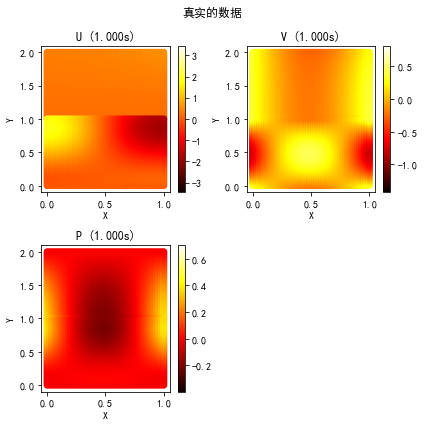

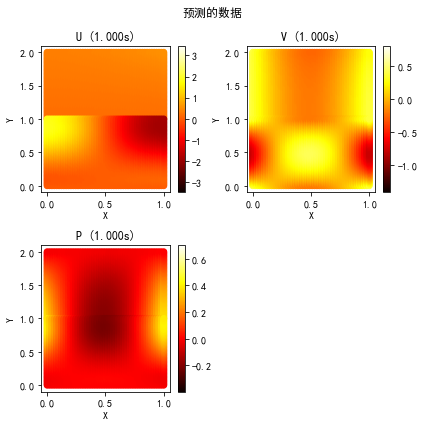

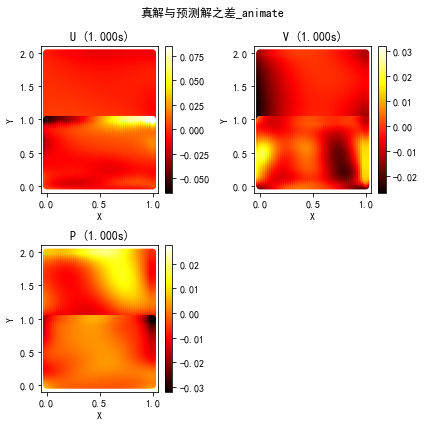

In [8]:
plot_diff(Example_Longtime2012,trained_combinedNet,test_output_dir)